#### Scan with Old detector at 7'' distance, with Rh source (0.5mCi) and FeCy absorber


In [109]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display

plt.style.use('Joey')

import numpy as np
import pandas as pd
import scipy.stats as sps
import datetime as datetime


import mossbauer
import utils as u

from scipy.integrate import simpson, quad, quad_vec
from scipy.special import jv
from scipy.interpolate import interp1d
from scipy.stats import norm
from matplotlib import gridspec


from scipy.ndimage import gaussian_filter

from os.path import join

from tqdm import tqdm
from mossbauer.materials import CobaltRhodiumMatrix, AlphaIron, PotassiumFerrocyanide

### FIT LORENTZIAN TO 25-POINT SCAN AND FIND EXPERIMENTAL PARAMETERS

{'activity': 170000000.0}
{'activity': 37000000.0}


Mean squared residual: 2.877e+01

Covariance Matrix:

       p[0]  p[1]  p[2]  p[3]
 p[0]  1.00
 p[1] -0.77  1.00
 p[2] -0.00  0.00  1.00
 p[3] -0.83  0.61  0.00  1.00

Final Parameters:

 p[0] = -5.45232e+01 +/- 2.2e+00 (4.02%)
 p[1] = 5.68690e+02 +/- 1.2e+00 (0.21%)
 p[2] = -1.46932e-01 +/- 3.4e-03 (2.33%)
 p[3] = 2.68453e-01 +/- 1.2e-02 (4.57%)



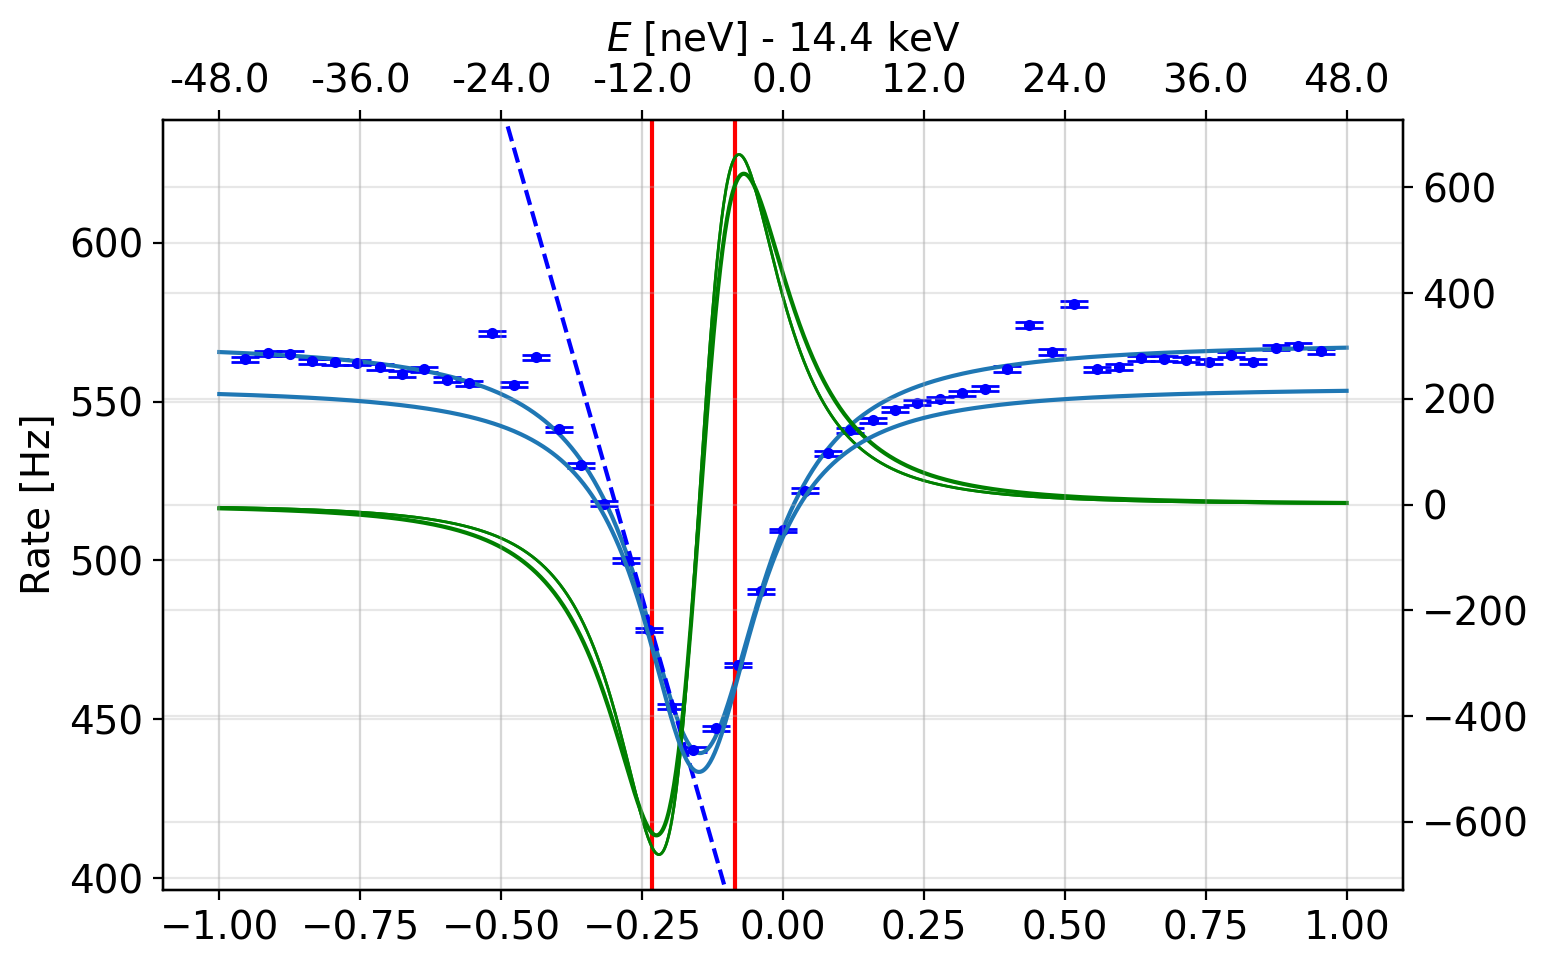

(179.13543802432693, -625.6219464703893, -621.3310117442114)

In [110]:
source = CobaltRhodiumMatrix(activity=1.7e8)  # default activity is the single-line source from chemistry (2.6 mCi on 8/30/2021 decayed till today)
#absorber = AlphaIron(abundance=0.02, thickness_microns=10)
absorber = PotassiumFerrocyanide()

### measurement parameters
source = CobaltRhodiumMatrix(activity=3.7e7)  # default activity is the single-line source from chemistry (2.6 mCi on 8/30/2021 decayed till today)
absorber = PotassiumFerrocyanide()

### measurement parameters
PMT_OD = 1.75 * 25.4  # mm
PMT_distance = 7 * 25.4  # mm
measurement_parameters = dict(
    acquisition_time=23.7*2*3600,  # (1 month) only really used for sensitivity calculations... maybe should be optional?
    solid_angle_fraction=(PMT_OD / PMT_distance)**2.0 / 16,
    background_rate=325,
    detection_efficiency=0.5  * (31521/43245) * (473/665 * 0.65),  # Be window * cardboard * empirical source rate difference (from background fits)
)


moss = mossbauer.MossbauerMeasurement(
    source,
    absorber,
    measurement_parameters
)


def lorentzian(p,x):
    A, B, E0, Gamma = p
    return 1/np.pi*A*Gamma/2/((x-E0)**2+(Gamma/2)**2)+B


def dlorentzian(p,x):
    A, B, E0, Gamma = p
    return -1/np.pi*A*Gamma*(x-E0)/((x-E0)**2+(Gamma/2)**2)**2


## Data
datadir = '/home/mossbauer/Data/mossbauer_data/'
fname = '20231004_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
data = pd.read_csv(join(datadir, fname))
data = data.groupby(['nominal_velocity']).sum()
rates_m = data['count']/data['DAQ_time']
rates_m[data.index>0] -= 0.4



fig = plt.figure()
ax = plt.gca()

vel = np.linspace(-1, 1, 1000)


plt.errorbar(
    -data.index.values,
    rates_m,
    yerr=rates_m/np.sqrt(data['count']), 
    fmt='b.',
    capsize=5
)

p0=[-100, 5000, -0.16, 0.16 ]
p,dp = u.fit(lorentzian,-data.index.values, rates_m, p0 )
A,B,E0,Gamma = p

plt.plot(vel, lorentzian(p,vel))
ax.plot(vel, dlorentzian(p,v1)*(vel-E0-v1)+B, color = 'b', linestyle = '--')
plt.axvline(v1,color = 'r')
plt.axvline(v2,color = 'r')



ax2 = ax.twinx()
ax2.plot(vel, dlorentzian(p,vel), color = 'g')
ax2.plot(vel , moss.transmitted_spectrum_derivative(vel), color = 'g', linewidth = 1)



ax.set_ylabel('Rate [Hz]')
ax.set_ylim(min(rates_m)*0.9,max(rates_m)*1.1)
mossbauer.add_energy_axis(ax)

plt.plot(vel, moss.transmitted_spectrum(vel))  # NOTE: derivative doesn't work for multi-line spectra
ax2.plot(vel , moss.transmitted_spectrum_derivative(vel), color = 'g', linewidth = 1)


plt.show()


4.7e-9/14e3/3e8
dlorentzian(p,-Gamma/2),dlorentzian(p,vel).min(),dlorentzian(p,v1)


### CLEANUP 2-POINT SCAN DATA

In [111]:
fname0 = '20231005_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
fname1 = '20231009_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
fname2 = '20231012_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'
fname3 = '20231017_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'

fnames = [fname0, fname1, fname2]
dataframes = []
for fname in fnames:
    datatemp = pd.read_csv(join(datadir, fname))
    dataframes.append(datatemp)
data = pd.concat(dataframes).reset_index()

idxall = []

vels = data.groupby('nominal_velocity', sort = False).mean().index
times = data.groupby('nominal_velocity', sort = False).mean()['DAQ_time']

todrop = len(data)%len(vels)
data = data.drop(data.tail(todrop).index)

for i,v in enumerate(vels):
    counts = data[data['nominal_velocity']==v]['count'].values
    mean = counts.mean()
    std = counts.std()
    idx = [j for j, c in enumerate(np.abs((counts-mean)/std)) if c>3]
    idx = list(np.array(idx)*len(vels))
    for k in range(len(vels)):
        idxall+=[x+k for x in idx]
        
data = data.drop(idxall)
data.to_csv(datadir + fname[:-4]+'_clean.dat')

In [112]:
fname

'20231012_scan/FeCy_0.25_mms_2steps_0.6-7in.dat'

### FIRST PLOT AND SENSITIVITY

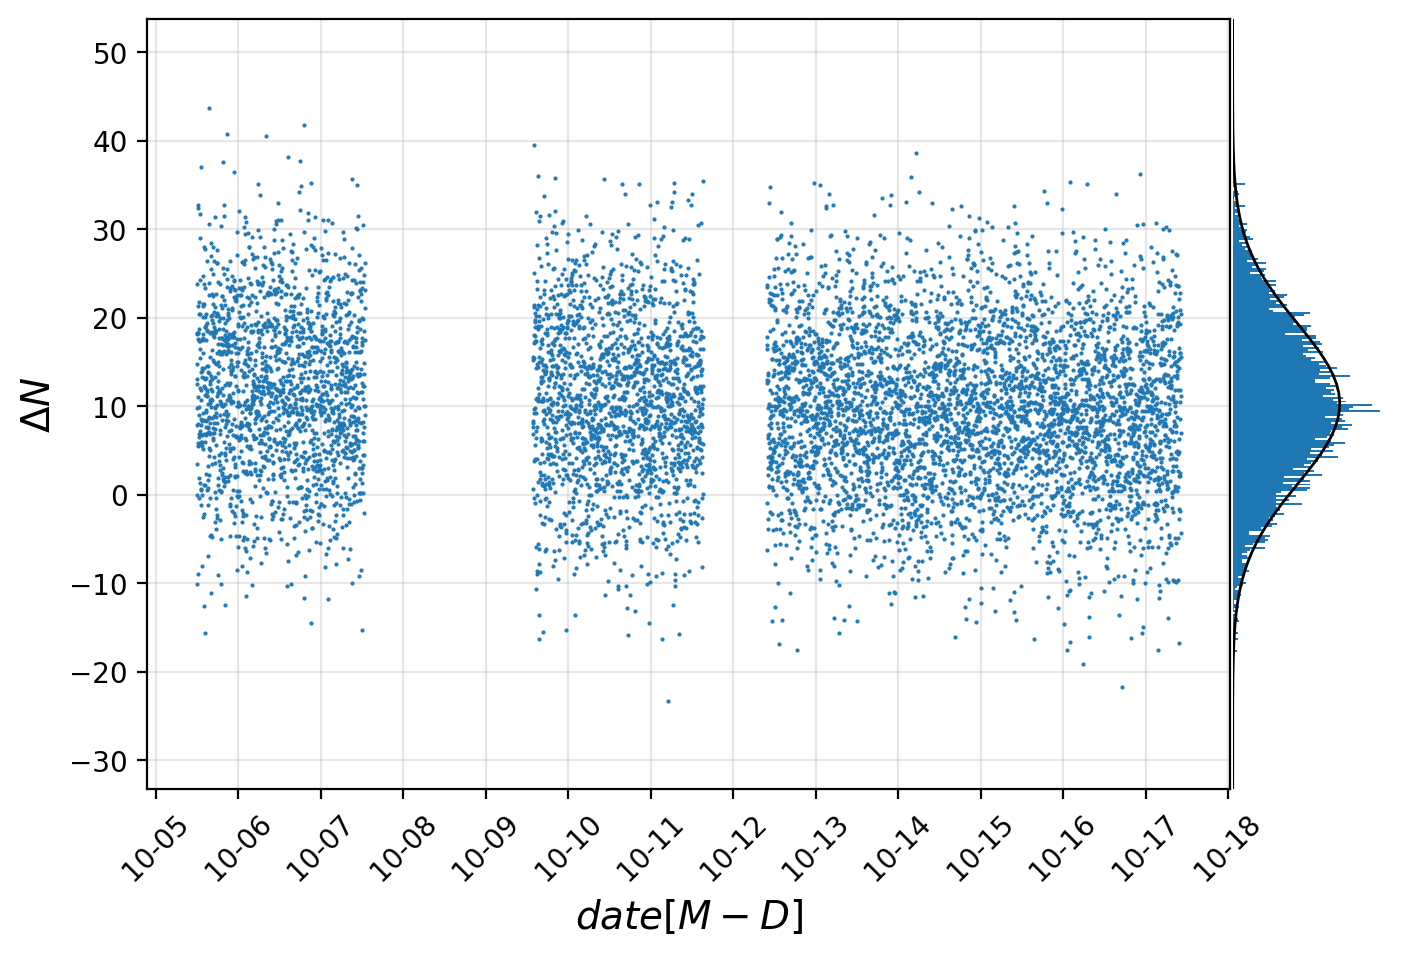

(10.276691285943665, 9.055739007585457, -2.57955859970909e-16, 8060)

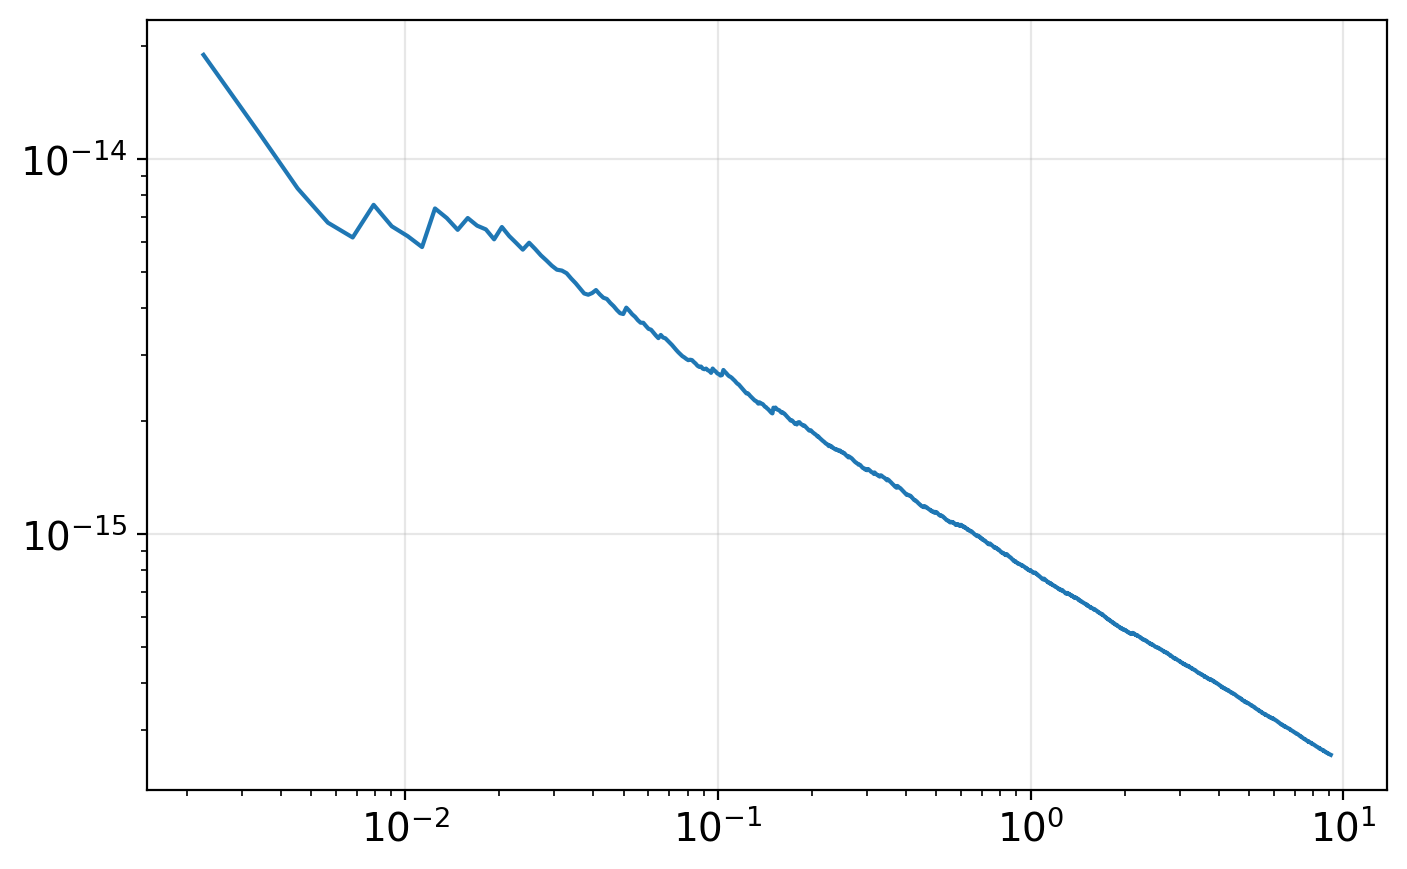

In [120]:
fname ='20231012_scan/FeCy_0.25_mms_2steps_0.6-7in_clean.dat'
data = pd.read_csv(join(datadir, fname))

#carefu, channels are inverted!
v1 = -0.2321399999999999
v2 = -0.08586

counts_v1 = data[data['nominal_velocity']==-v1]['count'].values
counts_v2 = data[data['nominal_velocity']==-v2]['count'].values

timestamps = data[data['nominal_velocity']==-v1]['time'].values
dates=[datetime.datetime.fromtimestamp(ts) for ts in timestamps]
diff = counts_v1/times[-v1]-counts_v2/times[-v2]

fig = plt.figure()
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[7, 1])

ax1 = fig.add_subplot(spec[0])


ax1.plot(dates, diff,'.',markersize = 1)
plt.xticks(rotation=45, fontsize = 10)
plt.yticks(fontsize = 10)


xfmt = md.DateFormatter('%m-%d', )
ax1.xaxis.set_major_formatter(xfmt)
ax1.xaxis.set_major_locator(md.DayLocator(interval=1))


ax2 = fig.add_subplot(spec[1], sharey = ax1)
h,b, pat  = plt.hist(diff, bins =300,density=True, orientation=u'horizontal',label='difference')
mu, std = norm.fit(diff)
ax2.plot(norm.pdf(np.linspace(-500,500,1000), mu, std), np.linspace(-500,500,1000), color = 'k',linewidth=1)

plt.ylim(min(diff)-10,max(diff)+10)

fig.subplots_adjust(wspace=0.004)
ax2.axis('off')


#ax1.set_xticks(ax1.get_xticks(), rotation=0)

v1 = -0.24804
v2 = -0.03816
dRdE_v1 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v1))])
dRdE_v2 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v2))])
dRdE_diff = dRdE_v1 - dRdE_v2

ax1.set_ylabel('$\Delta N$')
ax1.set_xlabel('$date [M-D]$')
plt.show()


n = pd.Series(diff).index.values[1:]+1
cumulative_time = n*(timestamps[1]-timestamps[0])
sens = pd.Series(diff).expanding().std()[1:].values/np.sqrt(n)/np.abs(dRdE_diff)/3e11

np.savetxt(datadir + fname[:-4]+'_sensitivityvstime.dat', [cumulative_time,sens])
plt.loglog(cumulative_time/3600/24,sens)

mu, std, std/np.sqrt(len(diff))/dRdE_diff/3e11, len(diff)

In [117]:
timestamps[1:-1]-timestamps[2:])

array([-97.83227301, -97.82986641, -97.83777523, ..., -97.92038035,
       -97.92705035, -97.90234566])

### SENSITIVITY AS A FUNCTION OF TIME

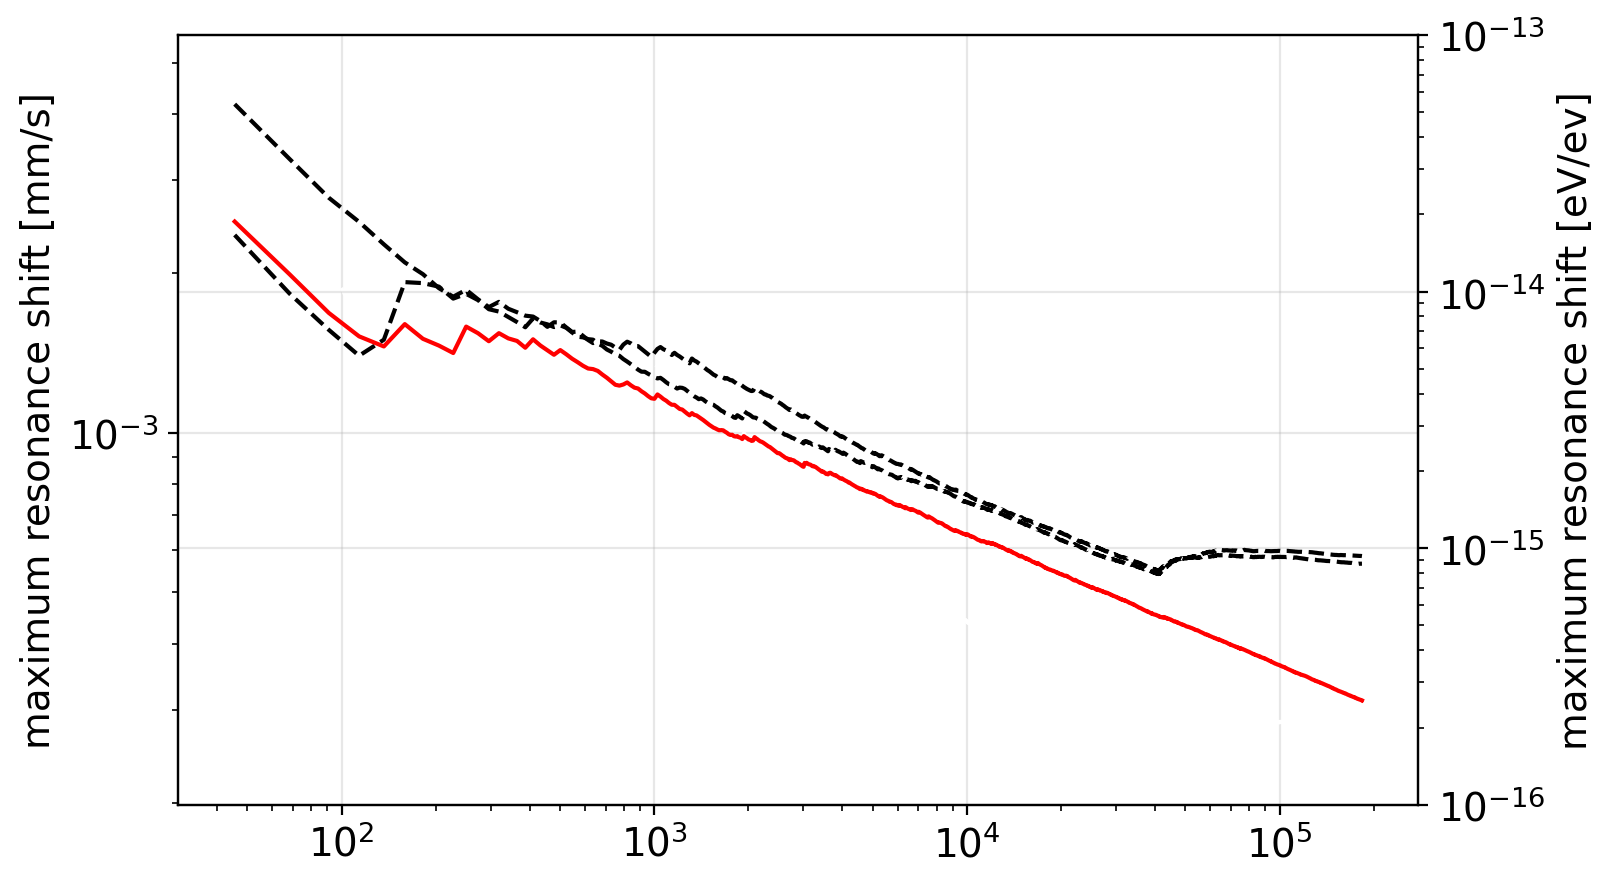

2.482367276843344e-16

In [99]:

fname ='20231012_scan/FeCy_0.25_mms_2steps_0.6-7in_clean.dat'
data = pd.read_csv(join(datadir, fname))

#carefu, channels are inverted!
v1 = -0.2321399999999999
v2 = -0.08586

datav1 = data[data['nominal_velocity']==-v1].reset_index()
datav2 = data[data['nominal_velocity']==-v2].reset_index()

sigma_rate_v1 = (datav1['count']/datav1['DAQ_time']).expanding().std().values[1:]
sigma_rate_v2 = (datav2['count']/datav2['DAQ_time']).expanding().std().values[1:]

sigma_rate_diff = ((datav1['count']/datav1['DAQ_time']-datav2['count']/datav2['DAQ_time'])).expanding().std().values[1:]
n = datav1.index.values[1:]+1

delta_rate_v1 = sigma_rate_v1/np.sqrt(n)
delta_rate_v2 = sigma_rate_v2/np.sqrt(n)
delta_rate_diff = sigma_rate_diff/np.sqrt(n)

dt = (datav1['DAQ_time'][1]+datav2['DAQ_time'][1])
time = n*dt


fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()

vels = np.linspace(-1,1,10000)

dRdE_v1 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v1))])
dRdE_v2 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v2))])

dRdE_diff = dRdE_v1 - dRdE_v2


dEmin_v1 = delta_rate_v1/np.abs(dRdE_v1)
dEmin_v2 = delta_rate_v2/np.abs(dRdE_v2)
dEmin_diff = delta_rate_diff/np.abs(dRdE_diff)


ax.loglog(time, dEmin_v1, 'w--',label = 'single point -')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_v1)/14e3, 'k--',label = 'single point 1')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_v2)/14e3, 'k--',label = 'single point 2')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_diff)/14e3, 'r',label = 'diff')
ax2.set_yscale('log')
ax.set_yscale('log')
#plt.fill_between(time, 1/np.sqrt(n)-1/n, 1/np.sqrt(n)+1/n, color='C2',alpha = 0.5)


plt.xlabel('integration time [h]')
ax.set_ylabel('maximum resonance shift [mm/s]')
ax2.set_ylim(1e-16,1e-13)
ax2.set_ylabel('maximum resonance shift [eV/ev]')

plt.show()



np.savetxt(datadir + fname[:-4]+'_sensitivityvstime.dat', [time,mossbauer.vel_to_E(dEmin_diff)/14e3])
mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3

### OTHER PLOTS